# DBSCAN Clustering Analysis: Development Patterns Across Countries

### DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups points that are closely packed together while marking points in low-density regions as outliers. It is particularly effective for datasets with clusters of varying shapes and sizes, and it does not require specifying the number of clusters in advance. Key parameters include `eps` (maximum distance between points in a cluster) and `min_samples` (minimum number of points to form a dense region).


In this analysis, we explore how countries cluster together based on their development indicators. Using DBSCAN, we'll identify natural groupings and outliers in the global development landscape. This helps us understand:

1. Which countries form natural development clusters
2. Which countries are outliers in terms of their development patterns
3. How different development indicators influence these groupings



In [41]:
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import folium
from folium.plugins import MarkerCluster
from sklearn.neighbors import NearestNeighbors
import matplotlib as mpl
from branca.element import Template, MacroElement

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [42]:
#visualization style

plt.style.use('seaborn-v0_8-white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette(['#1f77b4', '#2ca02c'])
%matplotlib inline

## Data Collection and Preparation

In [43]:
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "CO2 emissions per capita",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "SP.POP.TOTL": "Population"
}


# Get data for the most recent year
df = wbdata.get_dataframe(indicators, country='all', date='2020')




In [44]:
df.head()

,GDP per capita,Life Expectancy,CO2 emissions per capita,Labor Force Participation,Military Expenditure,Population
country,,,,,,
Africa Eastern and Southern,1344.080962,63.766484,1421.7752,66.290927,1.125082,694446100.0
Africa Western and Central,1664.249176,57.364425,866.4966,70.803236,0.943009,474569351.0
Arab World,5648.341118,70.726559,2855.4014,44.124063,5.599424,453723239.0
Caribbean small states,10270.790474,71.627621,15.9304,58.067287,NaN,3092577.0
Central Europe and the Baltics,16450.877509,76.007403,859.8807,56.648008,1.930102,102046650.0


In [45]:
df = df.reset_index()
# Clean and prepare the data
df = df.dropna()
df = df.reset_index()

In [46]:
df.head()

,index,country,GDP per capita,Life Expectancy,CO2 emissions per capita,Labor Force Participation,Military Expenditure,Population
0,0,Africa Eastern and Southern,1344.080962,63.766484,1421.7752,66.290927,1.125082,6.944461e+08
1,1,Africa Western and Central,1664.249176,57.364425,866.4966,70.803236,0.943009,4.745694e+08
2,2,Arab World,5648.341118,70.726559,2855.4014,44.124063,5.599424,4.537232e+08
3,4,Central Europe and the Baltics,16450.877509,76.007403,859.8807,56.648008,1.930102,1.020466e+08
4,5,Early-demographic dividend,3240.951502,69.880131,11519.5735,54.211328,2.501433,3.396051e+09


In [47]:
# Get country coordinates for mapping
countries = wbdata.get_countries()

In [48]:
country_metadata = {
        c['name']: {
            'region': c.get('region', {}).get('value', 'Unknown'),
            'income': c.get('incomeLevel', {}).get('value', 'Unknown'),
            'iso3': c['id']
        }
        for c in countries
    }
 # Add metadata using country name matching
df['Region'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('region', 'Unknown'))
df['Income Group'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('income', 'Unknown'))
df['ISO3'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('iso3', 'Unknown'))


In [49]:
df

,index,country,GDP per capita,Life Expectancy,CO2 emissions per capita,Labor Force Participation,Military Expenditure,Population,Region,Income Group,ISO3
0,0,Africa Eastern and Southern,1344.080962,63.766484,1421.7752,66.290927,1.125082,6.944461e+08,Aggregates,Aggregates,AFE
1,1,Africa Western and Central,1664.249176,57.364425,866.4966,70.803236,0.943009,4.745694e+08,Aggregates,Aggregates,AFW
2,2,Arab World,5648.341118,70.726559,2855.4014,44.124063,5.599424,4.537232e+08,Aggregates,Aggregates,ARB
3,4,Central Europe and the Baltics,16450.877509,76.007403,859.8807,56.648008,1.930102,1.020466e+08,Aggregates,Aggregates,CEB
4,5,Early-demographic dividend,3240.951502,69.880131,11519.5735,54.211328,2.501433,3.396051e+09,Aggregates,Aggregates,EAR
...,...,...,...,...,...,...,...,...,...,...,...
185,254,United Kingdom,40201.681242,80.331756,399.6036,62.543000,2.162216,6.708123e+07,Europe & Central Asia,High income,GBR
186,255,United States,64411.373178,76.980488,5671.6044,61.556000,3.650514,3.315269e+08,North America,High income,USA
187,256,Uruguay,15789.685742,78.381000,38.9164,61.255000,2.035838,3.398968e+06,Latin America & Caribbean,High income,URY
188,264,Zambia,951.644317,63.361000,27.3441,60.872000,1.170496,1.905940e+07,Sub-Saharan Africa,Lower middle income,ZMB


In [50]:

country_coords = {c['id']: (c['latitude'], c['longitude']) for c in countries if c.get('latitude')}

# Add coordinates to our dataframe
df['coordinates'] = df['ISO3'].map(country_coords)


In [51]:
df = df.dropna(subset=['coordinates'])

In [52]:
df[['latitude', 'longitude']] = pd.DataFrame(df['coordinates'].tolist(), index=df.index, columns=['latitude', 'longitude'])
# The original line lacked the 'columns' argument. Adding it ensures that the DataFrame created from the list of tuples
# has two columns named 'latitude' and 'longitude', matching the columns in the original DataFrame where data is being assigned.
df = df.drop('coordinates', axis=1)

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

df

,index,country,GDP per capita,Life Expectancy,CO2 emissions per capita,Labor Force Participation,Military Expenditure,Population,Region,Income Group,ISO3,latitude,longitude
46,49,Afghanistan,510.787063,61.454000,26.6463,41.579,1.358857,39068979.0,South Asia,Low income,AFG,34.52280,69.176100
47,50,Albania,5370.778623,77.824000,7.9674,57.780,1.295836,2837849.0,Europe & Central Asia,Upper middle income,ALB,41.33170,19.817200
48,51,Algeria,3743.541952,73.257000,241.1320,39.552,6.658711,44042091.0,Middle East & North Africa,Upper middle income,DZA,36.73970,3.050970
49,54,Angola,1449.922867,63.116000,61.6801,74.729,1.736994,33451132.0,Sub-Saharan Africa,Lower middle income,AGO,-8.81155,13.242000
50,56,Argentina,8535.599380,75.878000,347.3124,56.023,0.734112,45191965.0,Latin America & Caribbean,Upper middle income,ARG,-34.61180,-58.417300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,254,United Kingdom,40201.681242,80.331756,399.6036,62.543,2.162216,67081234.0,Europe & Central Asia,High income,GBR,51.50020,-0.126236
186,255,United States,64411.373178,76.980488,5671.6044,61.556,3.650514,331526933.0,North America,High income,USA,38.88950,-77.032000
187,256,Uruguay,15789.685742,78.381000,38.9164,61.255,2.035838,3398968.0,Latin America & Caribbean,High income,URY,-34.89410,-56.067500
188,264,Zambia,951.644317,63.361000,27.3441,60.872,1.170496,19059395.0,Sub-Saharan Africa,Lower middle income,ZMB,-15.39820,28.293700


In [53]:
# Scale the features
scaler = StandardScaler()
features = ['GDP per capita', 'Life Expectancy', 'CO2 emissions per capita',
           'Labor Force Participation', 'Military Expenditure']
scaled_features = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(scaled_features, columns=features, index=df.index)

## Visualization

### Distribution & Correlations of Development Indicators

<Figure size 1400x1200 with 0 Axes>

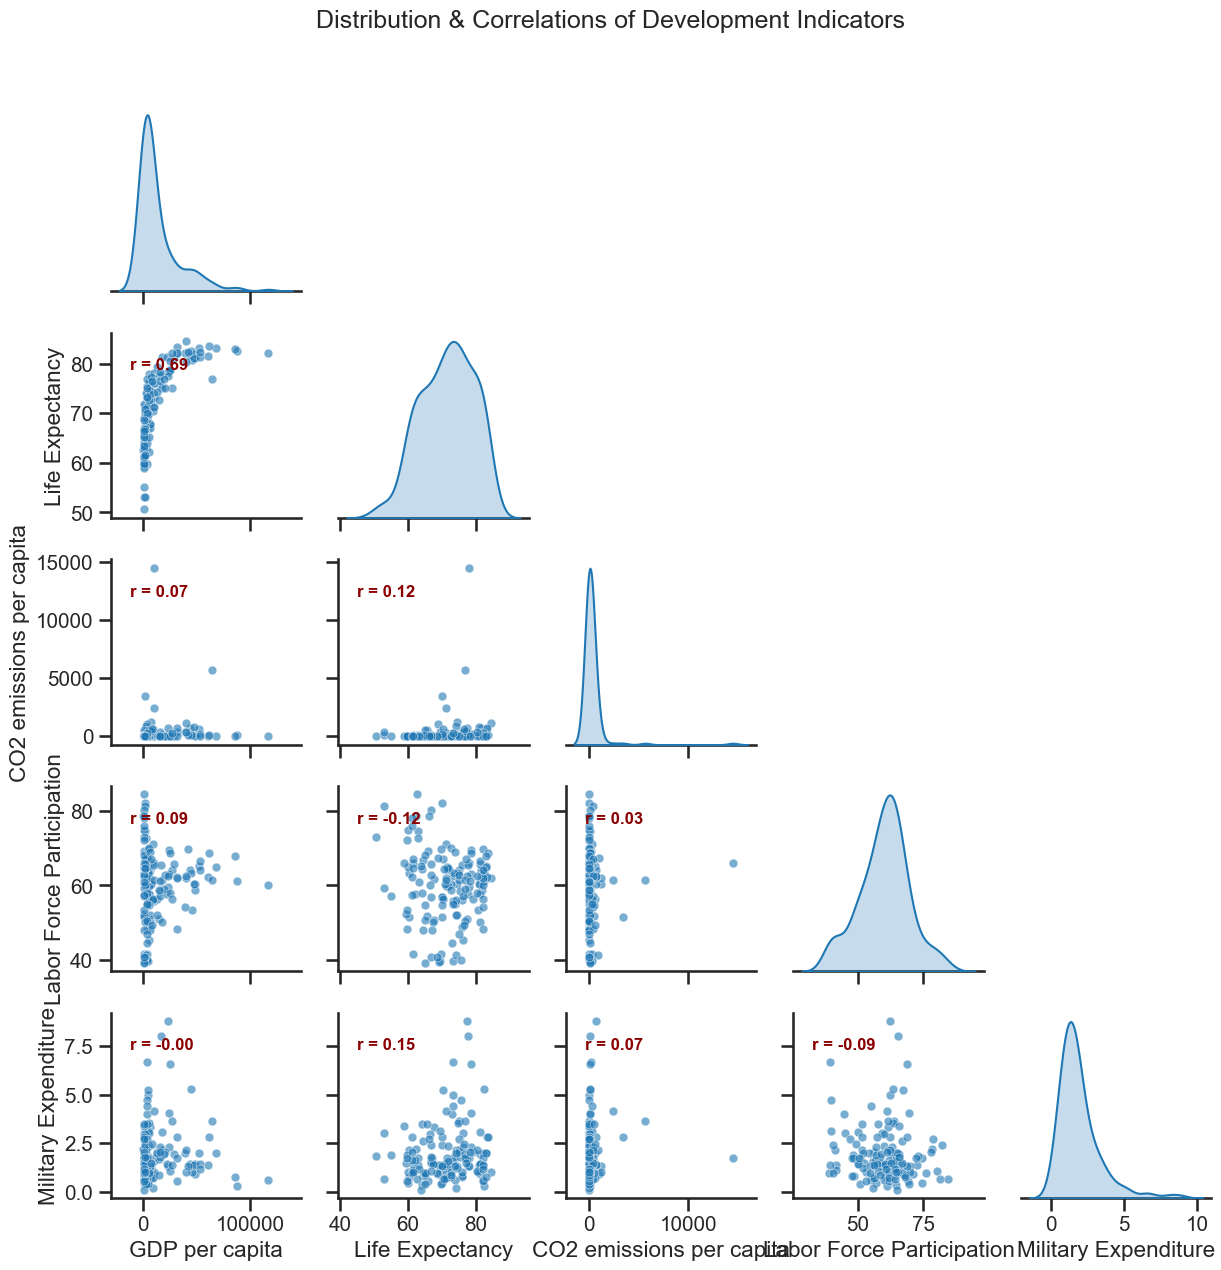

In [54]:
plt.figure(figsize=(14, 12))
g = sns.pairplot(
    df[features],
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 40},
    diag_kws={'fill': True}
)

# Annotate upper diagonals with Pearson r
for i, var1 in enumerate(features):
    for j, var2 in enumerate(features[:i]):
        ax = g.axes[i, j]
        r = df[var1].corr(df[var2])
        ax.annotate(f"r = {r:.2f}", xy=(0.1, 0.8), xycoords='axes fraction',
                    fontsize=12, fontweight='bold', color='darkred')

plt.suptitle('Distribution & Correlations of Development Indicators', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

## Pairplot Analysis: Development Indicators

The pairplot visualizes the distribution and relationships between key development indicators:

1. **Diagonal Plots**: Kernel Density Estimation (KDE) plots show the distribution of each indicator.
2. **Scatter Plots**: Off-diagonal plots display pairwise relationships between indicators.
3. **Correlation Coefficients**: Pearson correlation values (r) are annotated in the upper diagonal, highlighting the strength and direction of linear relationships.

Key Observations:
- Strong positive correlation between GDP per capita and Life Expectancy (r = 0.59).
- Weak or negligible correlations among other indicators.
- Distributions reveal varying ranges and skews for each indicator.


## Finding the Optimal DBSCAN Parameters

We'll use the k-distance plot to determine the optimal epsilon value (`eps`) for DBSCAN. The k-distance plot is a visualization that shows the distances to the k-th nearest neighbor (in this case, the 5th nearest neighbor) for all data points, sorted in ascending order. The "elbow point" on the curve represents a sharp change in slope, which indicates the optimal `eps` value for clustering. 

### Key Terminology:
- **Epsilon (`eps`)**: A parameter in DBSCAN that defines the maximum distance between two points for them to be considered as part of the same neighborhood.
- **k-distance**: The distance to the k-th nearest neighbor of a point. It is used to identify the density of points in the dataset.
- **Elbow Point**: A point on the k-distance plot where the slope of the curve changes sharply, indicating a transition from dense regions (clusters) to sparse regions (outliers).

In [55]:
from sklearn.neighbors import NearestNeighbors

# Calculate k-distance
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
k5 = np.sort(distances[:, 4])

elbow_index_1 = int(len(k5) * 0.33)  #33rd percentile
elbow_index_2 = int(len(k5) * 0.66)  #66th percentile

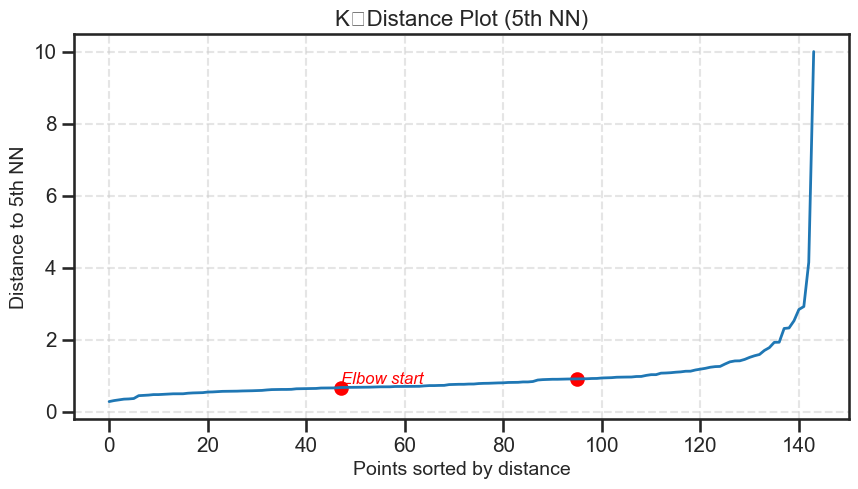

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(k5, linewidth=2)
plt.scatter([elbow_index_1, elbow_index_2], [k5[elbow_index_1], k5[elbow_index_2]], color='red')
plt.text(elbow_index_1, k5[elbow_index_1]+0.1, 'Elbow start', color='red', fontsize=12, fontstyle='italic')
plt.title('K‑Distance Plot (5th NN)', fontsize=16)
plt.xlabel('Points sorted by distance', fontsize=14)
plt.ylabel('Distance to 5th NN', fontsize=14)
plt.grid(linestyle='--', alpha=0.5)
plt.show()


The k-distance plot visualizes the distances to the 5th nearest neighbor for all data points, sorted in ascending order. The "elbow point" on the curve indicates a sharp change in slope, suggesting the optimal epsilon (eps) value for DBSCAN clustering. This value helps distinguish clusters from outliers effectively.

## Implementing DBSCAN Clustering
Based on the k-distance plot, we'll implement DBSCAN with appropriate parameters. The epsilon (`eps`) value is chosen based on the elbow point in the k-distance plot, and `min_samples` is set to 5 to ensure a minimum cluster density.


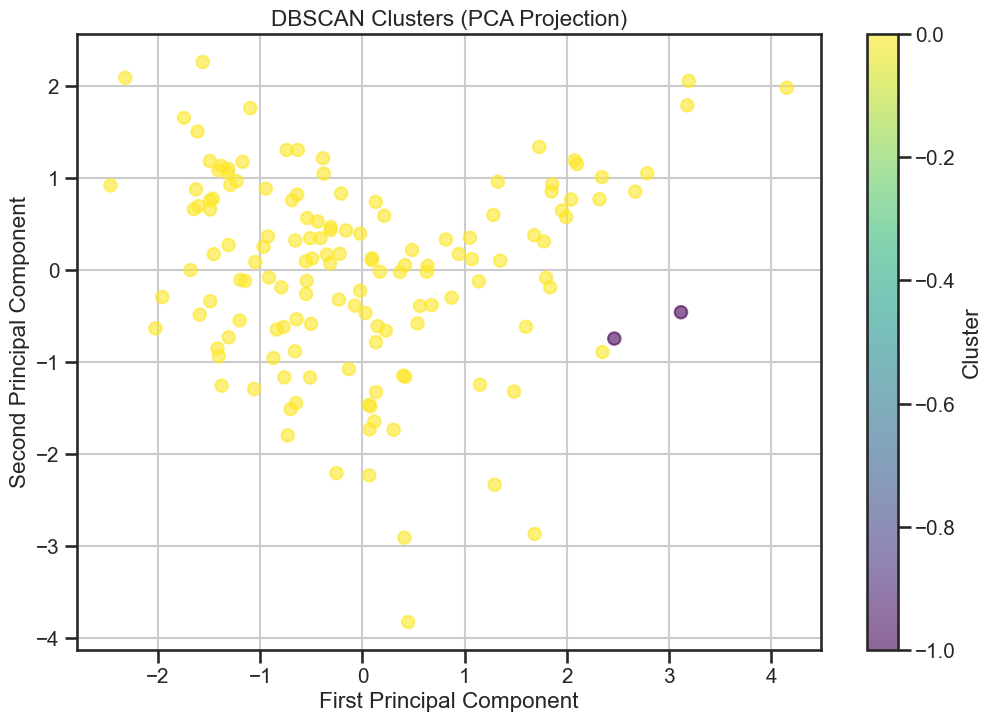

In [57]:
# Apply DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)
clusters = dbscan.fit_predict(df_scaled)

# Add cluster labels to the original dataframe
df['cluster'] = clusters

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                     c=clusters, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clusters (PCA Projection)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

### DBSCAN Clusters (PCA Projection)

The chart visualizes the clusters identified by the DBSCAN algorithm, projected into two dimensions using PCA. Each point represents a country, colored by its assigned cluster. The axes correspond to the first two principal components, which capture the most variance in the data. This visualization helps to understand the separation between clusters and the presence of outliers (if any).

## Interactive Map Visualization

Let's create an interactive map to visualize the clusters geographically.

In [58]:
# Define the colormap for distinct cluster colors
cmap = plt.get_cmap('tab10')

# Compute unique clusters and assign colors
unique_clusters = sorted(df['cluster'].unique())
if -1 in unique_clusters:
    colors = {-1: '#808080'}  # Gray for outliers
    clusters_without_outliers = [c for c in unique_clusters if c != -1]
else:
    colors = {}
    clusters_without_outliers = unique_clusters

for i, cluster in enumerate(clusters_without_outliers):
    colors[cluster] = mpl.colors.to_hex(cmap(i % 10))

# Initialize the Folium map, centered on the data's mean coordinates
m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=3)

# Normalize GDP for marker sizing using a logarithmic scale
gdp_log = np.log1p(df['GDP per capita'])
gdp_norm = (gdp_log - gdp_log.min()) / (gdp_log.max() - gdp_log.min())
sizes = (gdp_norm * 20) + 5  # Scale sizes between 5 and 25

# Add markers for each country with popups
for (_, row), size in zip(df.iterrows(), sizes):
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=size,
        color=colors[row.cluster],
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row.country}</b><br>Cluster: {row.cluster}<br>GDP per capita: ${row['GDP per capita']:,}<br>Life Exp.: {row['Life Expectancy']:.1f} yrs",
            max_width=300
        ),
        tooltip=f"{row.country}: Cluster {row.cluster}"
    ).add_to(m)

# Calculate cluster counts for the legend
cluster_counts = df['cluster'].value_counts().to_dict()

# Create an HTML legend showing cluster colors and counts
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius:6px;
    box-shadow: 3px 3px 3px rgba(0,0,0,0.25);
">
<strong>Cluster Legend</strong><br>
{% for c, col in colors.items() %}
  <i style="background: {{col}}; width: 12px; height: 12px;
            float: left; margin-right: 6px; opacity:0.7;"></i>
  Cluster {{c}} ({{cluster_counts[c]}} countries)<br>
{% endfor %}
</div>
{% endmacro %}
"""

# Attach the legend to the map
template = Template(legend_html)
template.environment.globals['colors'] = colors
template.environment.globals['cluster_counts'] = cluster_counts
legend = MacroElement()
legend._template = template
m.get_root().add_child(legend)

# Add a simple size legend for GDP per capita
size_legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    right: 50px;
    width: 150px;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius:6px;
    box-shadow: 3px 3px 3px rgba(0,0,0,0.25);
">
<strong>GDP per Capita (log scale)</strong><br>
<i style="background: #ccc; width: 10px; height: 10px; display: inline-block;"></i> Low<br>
<i style="background: #ccc; width: 20px; height: 20px; display: inline-block;"></i> Medium<br>
<i style="background: #ccc; width: 30px; height: 30px; display: inline-block;"></i> High
</div>
{% endmacro %}
"""
size_legend = MacroElement()
size_legend._template = Template(size_legend_html)
m.get_root().add_child(size_legend)

# Display the map
m

## Cluster Analysis and Insights

Let's analyze the characteristics of each cluster to understand the development patterns.

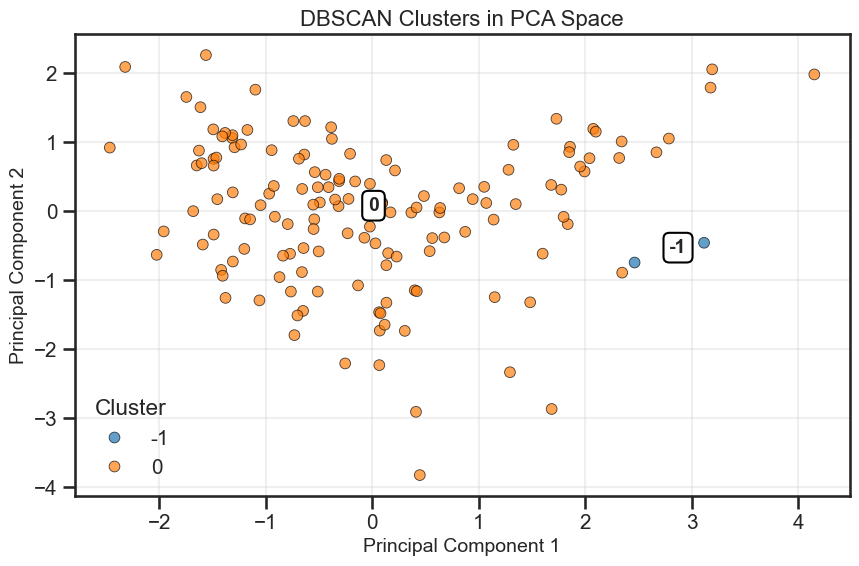

In [59]:
pca = PCA(n_components=2)
labels = df['cluster']
pca_proj = pca.fit_transform(df_scaled)
centroids = pd.DataFrame({
    'PC1': pca_proj[:,0],
    'PC2': pca_proj[:,1],
    'cluster': labels
}).groupby('cluster').mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_proj[:,0], y=pca_proj[:,1],
                hue=labels, palette='tab10', s=60, alpha=0.7, edgecolor='k')
for cid, (x, y) in centroids.iterrows():
    plt.text(x, y, str(cid), fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.title('DBSCAN Clusters in PCA Space', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', loc='best')
plt.grid(alpha=0.3)
plt.show()


### DBSCAN Clusters in PCA Space

The chart illustrates the clusters identified by the DBSCAN algorithm, projected into a two-dimensional space using Principal Component Analysis (PCA). Each point represents a country, with colors indicating cluster membership. Outliers are marked as cluster `-1`. The labeled centroids represent the average position of each cluster in the PCA space, providing a visual summary of cluster separation and cohesion.


<Figure size 1600x1000 with 0 Axes>

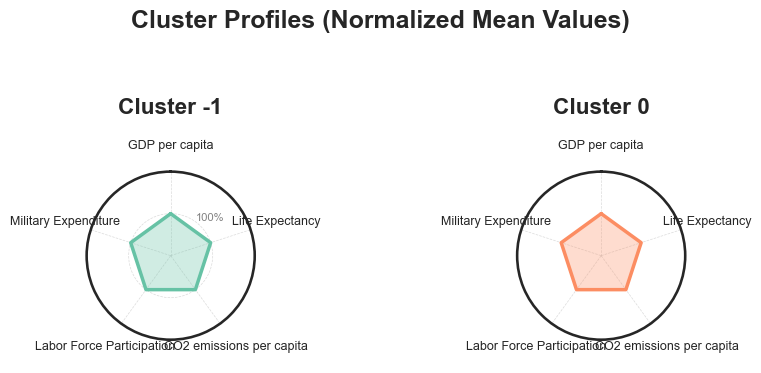

In [60]:
# 1. Normalize cluster means to [0,1]
plt.figure(figsize=(16, 10))
cluster_stats = df.groupby('cluster')[features].mean()
cluster_stats_norm = cluster_stats.copy()
for col in features:
    min_, max_ = cluster_stats[col].min(), cluster_stats[col].max()
    cluster_stats_norm[col] = (cluster_stats[col] - min_) / (max_ - min_)

# 2. Prepare plotting angles
N = len(features)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# 3. Set up figure
num = min(len(cluster_stats_norm), 4)
fig, axes = plt.subplots(1, num, figsize=(4*num, 4), subplot_kw=dict(polar=True))
if num == 1:
    axes = [axes]

# 4. Color palette
palette = plt.get_cmap('Set2')

for idx, (ax, (cluster, stats)) in enumerate(zip(axes, cluster_stats_norm.iterrows())):
    values = stats.tolist()
    values += values[:1]

    # Plot concentric circles / grid
    ax.set_theta_offset(np.pi / 2)       # start from top
    ax.set_theta_direction(-1)           # clockwise
    ax.set_rlabel_position(180 / N)      # radial labels offset
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['25%', '50%', '75%', '100%'], color="gray", size=8)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Plot data
    color = palette(idx)
    ax.plot(angles, values, color=color, linewidth=2.5)
    ax.fill(angles, values, color=color, alpha=0.3)

    # Set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=9)

    # Title
    ax.set_title(f'Cluster {cluster}', y=1.3, fontweight='bold')

# 5. Global title and legend
plt.suptitle('Cluster Profiles (Normalized Mean Values)', fontsize=18, fontweight='bold')
# Draw legend outside the plots
plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.2), ncol=num, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Add spacing between subplots
plt.show()


### Cluster Profiles (Normalized Mean Values)

The radar chart compares the normalized mean values of key development indicators for each cluster. Each axis represents a development indicator, and the values are scaled between 0 and 1 for comparison. 

- **Cluster -1**: Represents outliers with relatively balanced but lower values across most indicators.
- **Cluster 0**: Represents the main cluster with higher values for GDP per capita and Life Expectancy, but lower Military Expenditure.

This visualization highlights the distinct profiles of each cluster, aiding in understanding their development patterns.

### Conclusions

Based on our analysis, we can tell the following story about global development patterns:

1. **Natural Development Clusters**: Countries naturally group into distinct clusters based on their development indicators. These clusters represent different stages of development and unique combinations of economic, health, and environmental factors.

2. **Outliers and Anomalies**: Some countries stand out as outliers, either due to unique development paths or data anomalies. These outliers provide interesting case studies for understanding exceptional development patterns.

3. **Geographic Patterns**: The clusters show interesting geographic patterns, with certain regions of the world tending to fall into similar development categories.

4. **Development Trade-offs**: The analysis reveals interesting trade-offs between different development indicators, such as the relationship between economic growth and environmental impact.

## Recommendations

1. **Policy Implications**: Countries in similar clusters can learn from each other's development strategies.
2. **Sustainable Development**: The analysis can help identify sustainable development pathways that balance economic growth with environmental protection.
3. **International Cooperation**: Countries in similar clusters can form partnerships to address common development challenges.
